# Import Libraires 

In [7]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

# Load Data

In [8]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '../input/image-super-resolution/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '../input/image-super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:03<00:00, 231.41it/s]


# Data Visualization

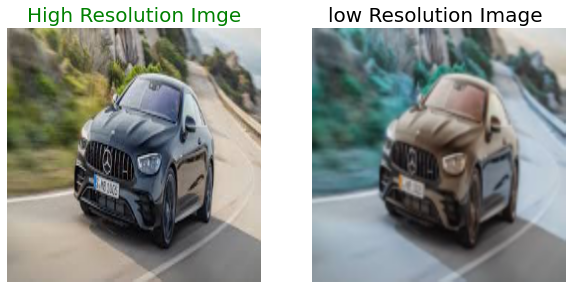

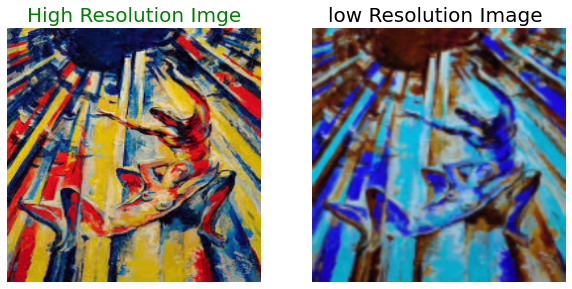

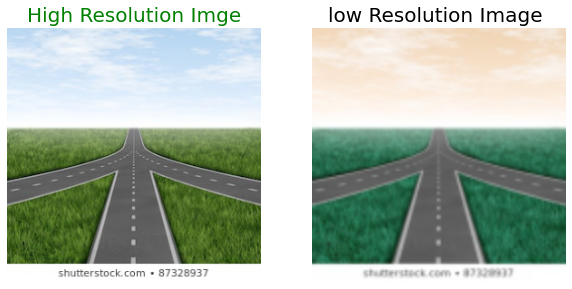

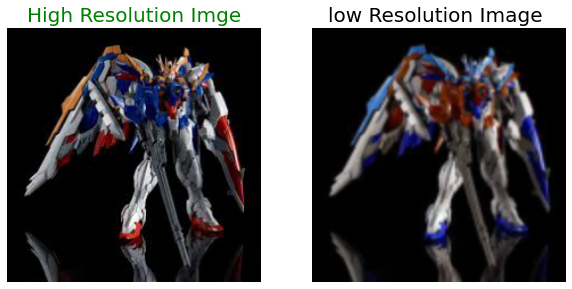

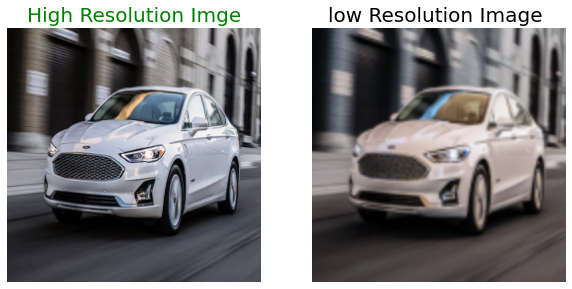

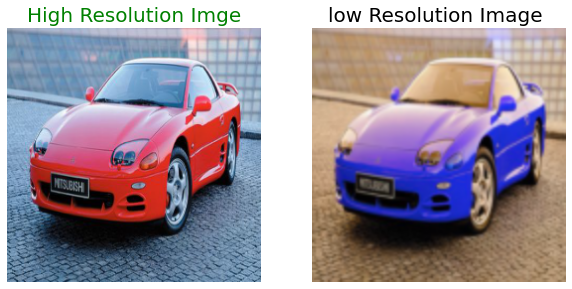

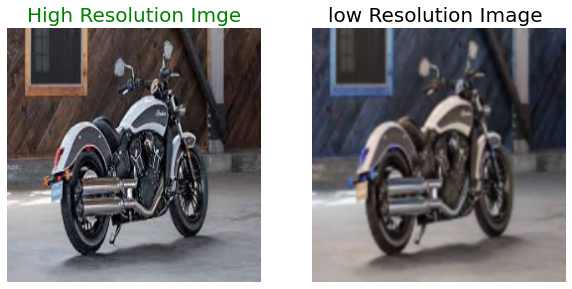

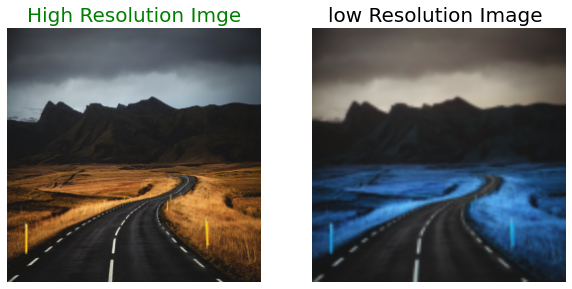

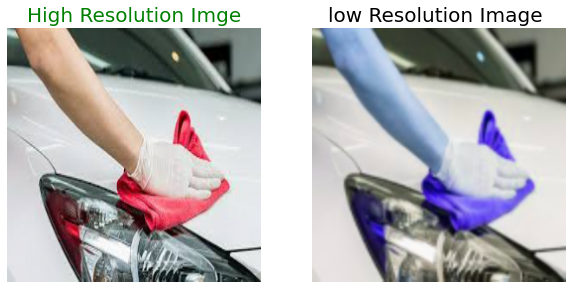

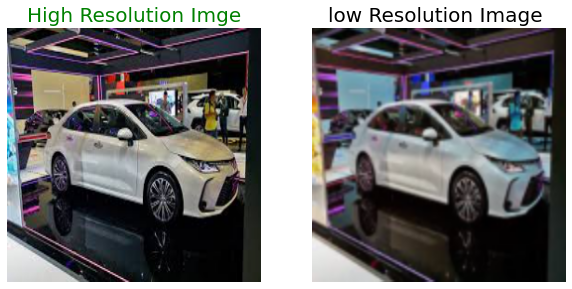

In [9]:
for i in range(10):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

# Slicing and Reshaping Images

In [4]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)


Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


# Defining Model

In [5]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  296192      sequential_1[0][0]               
______________________________________________________________________________________________

# Compile 

In [25]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = [])

# Fitting model

In [28]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Define image size
SIZE = 256

# Store PSNR, SSIM, Accuracy, and Loss values
psnr_values = []
ssim_values = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

# Custom callback to track PSNR, SSIM, and learning rate
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_predictions = model.predict(validation_low_image)
        avg_psnr = np.mean([psnr(validation_high_image[i], val_predictions[i], data_range=1) 
                            for i in range(len(validation_high_image))])
        avg_ssim = np.mean([ssim(validation_high_image[i], val_predictions[i], multichannel=True, data_range=1) 
                            for i in range(len(validation_high_image))])
        
        psnr_values.append(avg_psnr)
        ssim_values.append(avg_ssim)

        # Store loss, accuracy, and learning rate
        train_losses.append(logs["loss"])
        val_losses.append(logs["val_loss"])
        if "accuracy" in logs:
            train_accuracies.append(logs["accuracy"])
            val_accuracies.append(logs["val_accuracy"])
        
        optimizer = model.optimizer
        learning_rates.append(optimizer.lr.numpy())

        print(f"Epoch {epoch+1} - PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")

# Train model and track metrics
history = model.fit(
    train_low_image, train_high_image,
    epochs=7,
    batch_size=1,
    validation_data=(validation_low_image, validation_high_image),
    callbacks=[MetricsCallback()]
)

Epoch 1/7
700/700 [==============================] - 14s 20ms/step - loss: 0.0136 - val_loss: 0.0167
Epoch 1 - PSNR: 31.53 dB, SSIM: 0.9327, Loss: 0.0136, Val Loss: 0.0167
Epoch 2/7
700/700 [==============================] - 14s 20ms/step - loss: 0.0135 - val_loss: 0.0166
Epoch 2 - PSNR: 31.51 dB, SSIM: 0.9328, Loss: 0.0135, Val Loss: 0.0166
Epoch 3/7
700/700 [==============================] - 14s 20ms/step - loss: 0.0132 - val_loss: 0.0163
Epoch 3 - PSNR: 31.66 dB, SSIM: 0.9350, Loss: 0.0132, Val Loss: 0.0163
Epoch 4/7
700/700 [==============================] - 14s 20ms/step - loss: 0.0132 - val_loss: 0.0172
Epoch 4 - PSNR: 31.41 dB, SSIM: 0.9281, Loss: 0.0132, Val Loss: 0.0172
Epoch 5/7
700/700 [==============================] - 14s 20ms/step - loss: 0.0131 - val_loss: 0.0162
Epoch 5 - PSNR: 31.64 dB, SSIM: 0.9347, Loss: 0.0131, Val Loss: 0.0162
Epoch 6/7
700/700 [==============================] - 14s 21ms/step - loss: 0.0129 - val_loss: 0.0167
Epoch 6 - PSNR: 31.53 dB, SSIM: 0.9332,

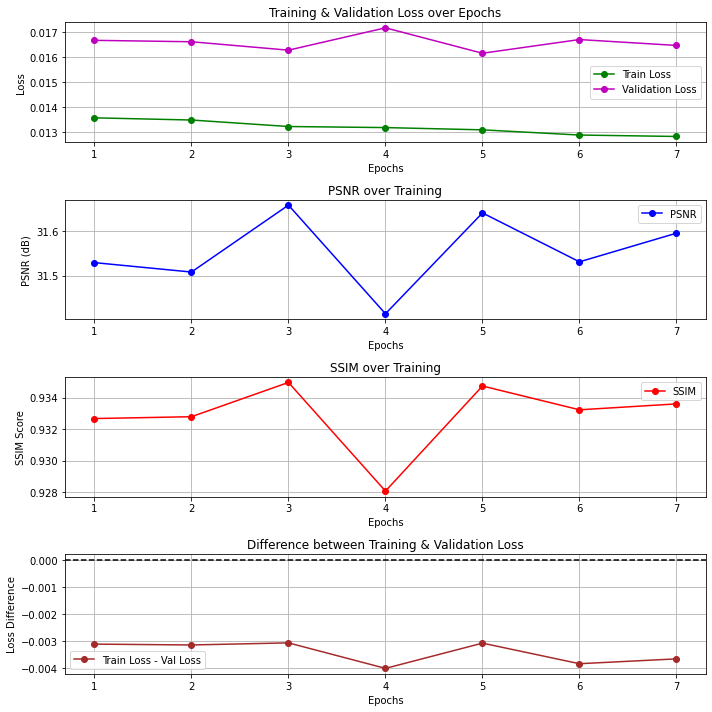

In [31]:
# Number of subplots
num_plots = 4
plt.figure(figsize=(10, 10))


# 1. Training & Validation Loss
plt.subplot(num_plots, 1, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='g', label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', color='m', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.legend()
plt.grid()

# 1. PSNR over Training
plt.subplot(num_plots, 1, 2)
plt.plot(range(1, len(psnr_values) + 1), psnr_values, marker='o', color='b', label="PSNR")
plt.xlabel("Epochs")
plt.ylabel("PSNR (dB)")
plt.title("PSNR over Training")
plt.legend()
plt.grid()

# 3. SSIM over Training
plt.subplot(num_plots, 1, 3)
plt.plot(range(1, len(ssim_values) + 1), ssim_values, marker='o', color='r', label="SSIM")
plt.xlabel("Epochs")
plt.ylabel("SSIM Score")
plt.title("SSIM over Training")
plt.legend()
plt.grid()



# 4. Difference between Training & Validation Loss
plt.subplot(num_plots, 1, 4)
loss_diff = np.array(train_losses) - np.array(val_losses)
plt.plot(range(1, len(loss_diff) + 1), loss_diff, marker='o', color='brown', label="Train Loss - Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss Difference")
plt.title("Difference between Training & Validation Loss")
plt.axhline(0, color='black', linestyle='--')  # Zero line for reference
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

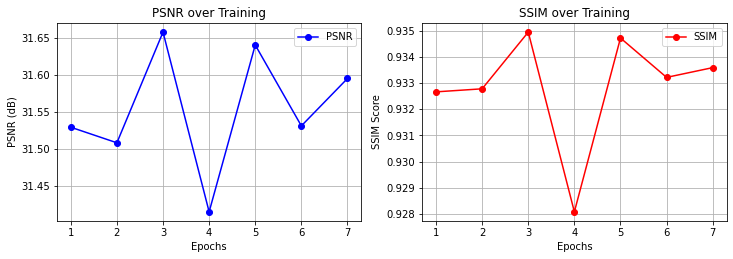

In [32]:
# Plot PSNR, SSIM, Loss, and Accuracy
plt.figure(figsize=(12, 8))

# PSNR Plot
plt.subplot(2, 2, 1)
plt.plot(range(1, len(psnr_values) + 1), psnr_values, marker='o', color='b', label="PSNR")
plt.xlabel("Epochs")
plt.ylabel("PSNR (dB)")
plt.title("PSNR over Training")
plt.legend()
plt.grid()

# SSIM Plot
plt.subplot(2, 2, 2)
plt.plot(range(1, len(ssim_values) + 1), ssim_values, marker='o', color='r', label="SSIM")
plt.xlabel("Epochs")
plt.ylabel("SSIM Score")
plt.title("SSIM over Training")
plt.legend()
plt.grid()

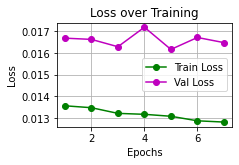

In [36]:
# Loss Plot
plt.subplot(2, 2, 3)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='g', label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', color='m', label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Training")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Prediction Visualization

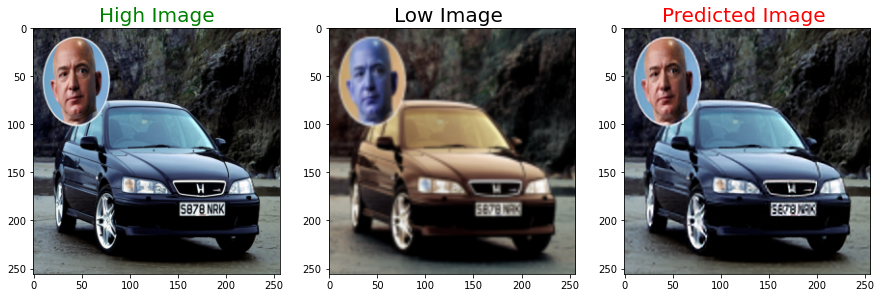

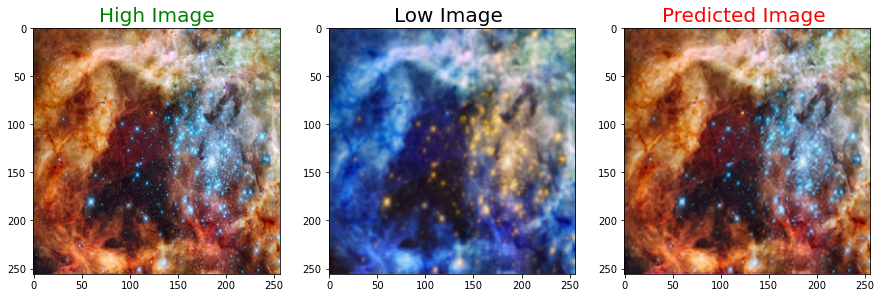

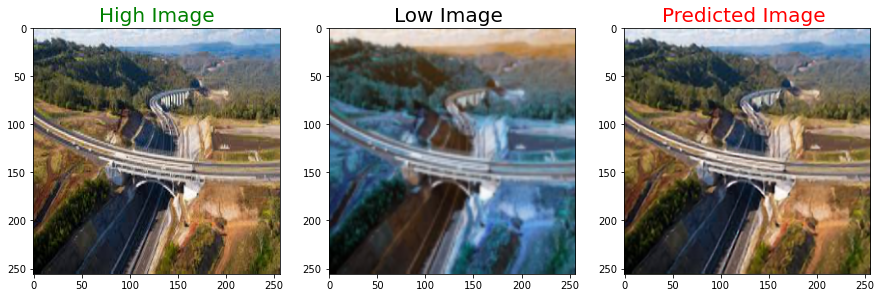

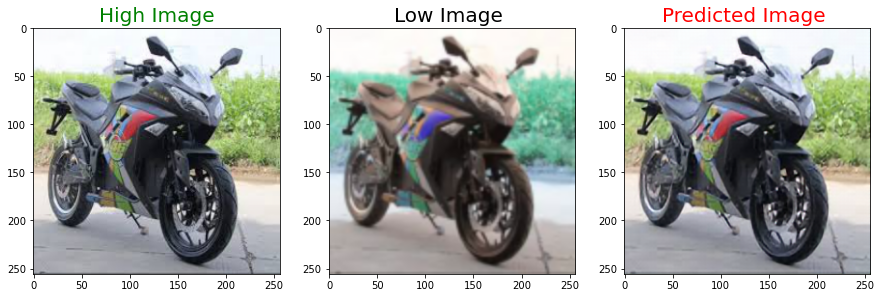

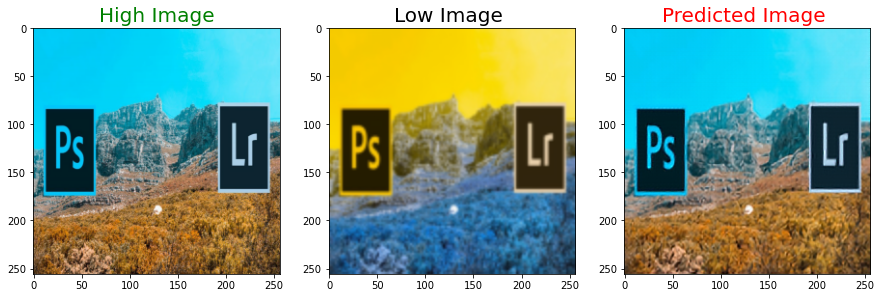

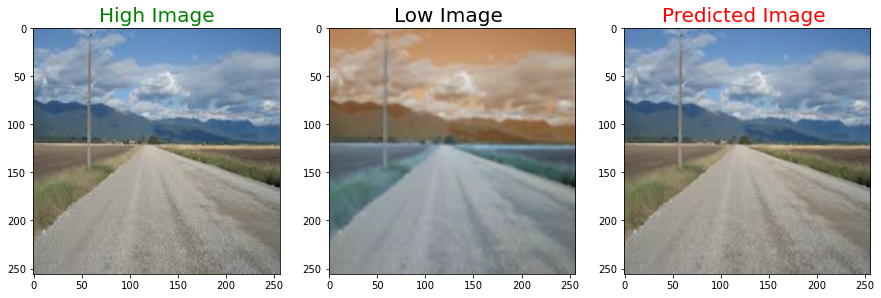

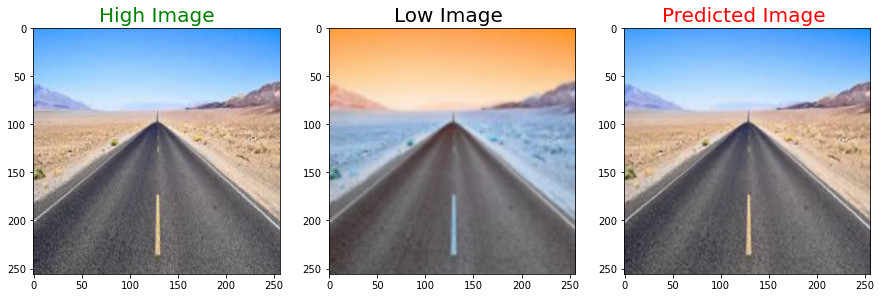

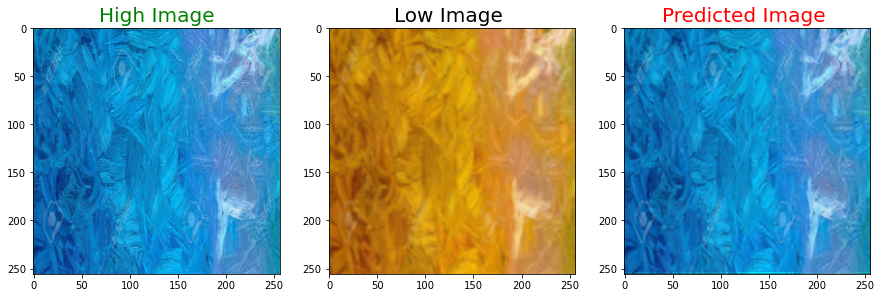

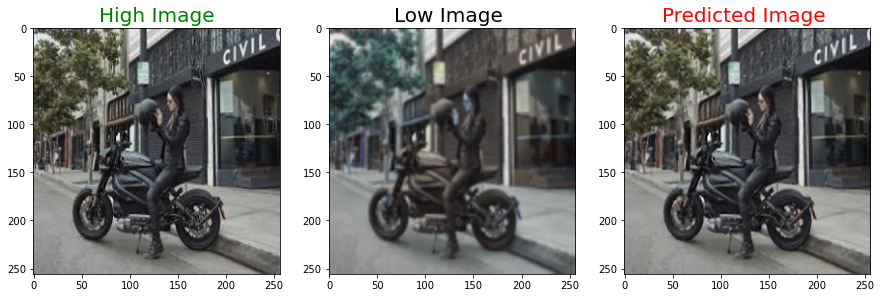

In [37]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

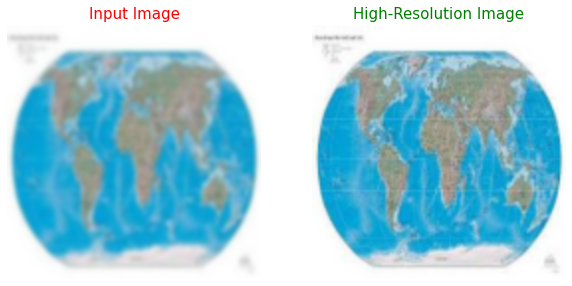

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

SIZE = 256  # Image size

def f(high_res_path):
    
    # Load high-resolution image
    high_img = cv2.imread(high_res_path)
    high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    high_img = cv2.resize(high_img, (SIZE, SIZE))  # Resize to fixed size

    # Generate low-resolution version
    low_img = cv2.resize(high_img, (SIZE // 2, SIZE // 2))  # Downscale to half size
    low_img = cv2.resize(low_img, (SIZE, SIZE))  # Upscale back to original size
    low_img = cv2.GaussianBlur(low_img, (7, 7), 2)  # Apply Gaussian Blur

    # Plot the images
    plt.figure(figsize=(10, 5))

    # Low-resolution image
    plt.subplot(1, 2, 1)
    plt.title('Input Image', color='red', fontsize=15)
    plt.imshow(low_img)
    plt.axis('off')

    # High-resolution image
    plt.subplot(1, 2, 2)
    plt.title('High-Resolution Image', color='green', fontsize=15)
    plt.imshow(high_img)
    plt.axis('off')

    plt.show()

# Example usage
f("/kaggle/input/image-super-resolution/dataset/train/low_res/100.png")  # Provide the correct image path


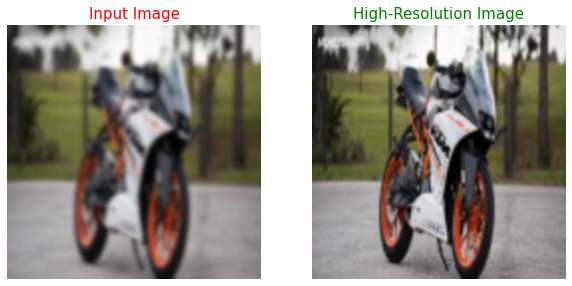

In [39]:
f("/kaggle/input/image-super-resolution/dataset/train/low_res/105.png")

# Saving model

In [40]:
model.save("attention.h5")

In [41]:
model = tf.keras.models.load_model("attention.h5", compile=False)


In [42]:
import tensorflow as tf

model = tf.keras.models.load_model("attention.h5")

# Save the model in a compatible format
model.save("my_model_fixed.h5")
